In [1]:
!unzip /content/data.zip

Archive:  /content/data.zip
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).png  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (10).tif  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (100).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1001).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1002).JPG  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1003).jpg  
  inflating: Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1004).jpg  
  inflating: Brain Tumor Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob
import shutil

In [3]:
# number of images in directory
root_dir="/content/Brain Tumor Data Set/Brain Tumor Data Set"
no_of_images={}
for dir in os.listdir(root_dir):
  # no_of_images[dir]=os.listdir(os.path.join(root_dir,dir))
  no_of_images[dir]=len(os.listdir(os.path.join(root_dir,dir)))
no_of_images.items()

dict_items([('Brain Tumor', 2513), ('Healthy', 2087)])

In [4]:
os.listdir("/content/Brain Tumor Data Set/Brain Tumor Data Set")

['Brain Tumor', 'Healthy']

In [5]:
len(os.listdir("/content/Brain Tumor Data Set/Brain Tumor Data Set"))

2

# Split data
##70% training data
## 15% validation data
## 15% testing data

In [6]:
# train folder
def datafolder(p,split):
  if not os.path.exists("./"+p):
    os.mkdir("./"+p)
    for dir in os.listdir(root_dir):
      os.makedirs("./"+p+"/"+dir)
      for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)),
                                  size=(math.floor(split*no_of_images[dir])-2),
                                  replace=False):
        o=os.path.join(root_dir,dir,img)
        d=os.path.join("./"+p,dir)
        shutil.copy(o,d)
        os.remove(o)
  else:
    print(f"{p}folder exists")

In [7]:
datafolder("train",0.7)

In [8]:
datafolder("val",0.15)

In [9]:
datafolder("test",0.15)

### model build

In [10]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential,Model,load_model
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.mobilenet import MobileNet,preprocess_input
import keras

In [11]:
basemodel=MobileNet(input_shape=(224,224,3),include_top=False)

17235968/17225924 [==============================] - 0s 0us/step


In [12]:
for layer in basemodel.layers:
  layer.trainable=False

In [13]:
basemodel.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [14]:
from keras.backend import flatten
x=Flatten()(basemodel.output)
x=Dense(units=1,activation='sigmoid')(x)
model=Model(basemodel.input,x)

In [15]:
# CNN Model
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=(3,3),activation="relu",input_shape=(224,224,3)))
model.add(Conv2D(filters=36,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=128,kernel_size=(3,3),activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [16]:
model.compile(optimizer='rmsprop',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

###preparing data using data generator

In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
def preprocessingImages(path):
  """
  input : path
  output: preprocessed image
  """
  image_data=ImageDataGenerator(zoom_range=0.2,shear_range=0.2,rescale=1/255,horizontal_flip=True)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

In [19]:
path="/content/train"
train_data=preprocessingImages(path)

Found 3215 images belonging to 2 classes.


In [33]:
def preprocessingImages2(path):
  """
  input : path
  output: preprocessed image
  """
  image_data=ImageDataGenerator(preprocessing_function=preprocess_input,zoom_range=0.2,horizontal_flip=True,shear_range=0.2,rescale=1/255)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

In [34]:
path="/content/test"
test_data=preprocessingImages2(path)

Found 685 images belonging to 2 classes.


In [35]:
path="/content/val"
val_data=preprocessingImages2(path)

Found 685 images belonging to 2 classes.


In [44]:
# early stopping
from keras.callbacks import ModelCheckpoint,EarlyStopping
es=EarlyStopping(monitor='accuracy',min_delta=0.01,verbose=1,patience=3,mode='auto')
# model checkpoint
mcheck=ModelCheckpoint(monitor='accuracy',filepath='./bestmodel.h5',verbose=1,save_best_only=True,mode='auto')
cd=[es,mcheck]

In [45]:
from keras import callbacks
# model training
hs=model.fit_generator(generator=train_data,steps_per_epoch=8,epochs=20,verbose=1,validation_data=test_data,validation_steps=16,callbacks=cd)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.6680
Epoch 1: accuracy improved from -inf to 0.66797, saving model to ./bestmodel.h5
8/8 [==============================] - 69s 9s/step - loss: 0.6337 - accuracy: 0.6680 - val_loss: 0.6926 - val_accuracy: 0.5391
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.7148
Epoch 2: accuracy improved from 0.66797 to 0.71484, saving model to ./bestmodel.h5
8/8 [==============================] - 68s 9s/step - loss: 0.5722 - accuracy: 0.7148 - val_loss: 0.8421 - val_accuracy: 0.5410
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.5478 - accuracy: 0.7305
Epoch 3: accuracy improved from 0.71484 to 0.73047, saving model to ./bestmodel.h5
8/8 [==============================] - 68s 9s/step - loss: 0.5478 - accuracy: 0.7305 - val_loss: 0.7942 - val_accuracy: 0.5566
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.6119 - accuracy: 0.6836
Epoch

In [46]:
h=hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

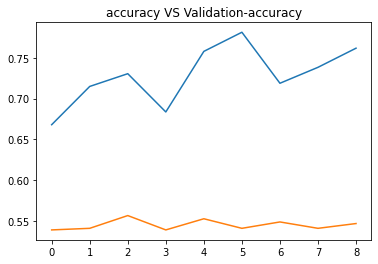

In [47]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])
plt.title('accuracy VS Validation-accuracy')
plt.show()

In [48]:
from keras.models import load_model
model=load_model("/content/bestmodel.h5")

In [52]:
# Accuracy
acc=model.evaluate(test_data)[0]
print("Accuracy is :" ,acc*100,"%")

22/22 [==============================] - 35s 2s/step - loss: 0.7611 - accuracy: 0.5460
Accuracy is : 76.10762119293213 %


In [54]:
from keras.preprocessing.image import load_img,img_to_array

In [55]:
test_data.class_indices

{'Brain Tumor': 0, 'Healthy': 1}

Welcome To BrainCancer Detection Program


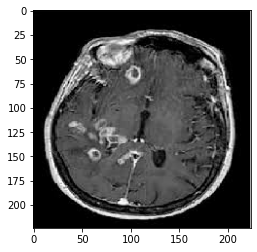

[[0.29174912]]
it has Brain tumor


In [57]:
def detect(path):
  print("Welcome To BrainCancer Detection Program")
  img=load_img(path,target_size=(224,224))
  img=img_to_array(img)/255
  
  plt.imshow(img)
  plt.show()
  img=np.expand_dims(img,axis=0)
  pred=model.predict(img)
  if pred>0.5:
    print(pred)
    print("it has no Brain tumor")
  else:
    print(pred)
    print("it has Brain tumor")
detect("/content/test/Brain Tumor/Cancer (1005).jpg")

Welcome To BrainCancer Detection Program


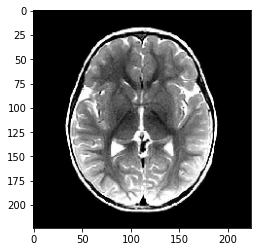

[[0.9662199]]
it has no Brain tumor


In [58]:
detect("/content/test/Healthy/Not Cancer  (1005).jpg")

Welcome To BrainCancer Detection Program


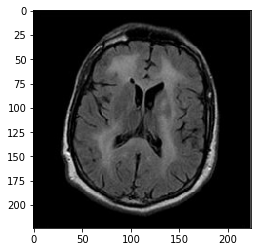

[[0.8564891]]
it has no Brain tumor


In [59]:
detect("/content/test/Healthy/Not Cancer  (101).jpg")

Welcome To BrainCancer Detection Program


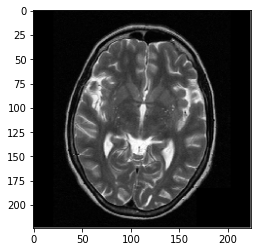

[[0.69544715]]
it has no Brain tumor


In [60]:
detect("/content/test/Healthy/Not Cancer  (1036).jpg")

Welcome To BrainCancer Detection Program


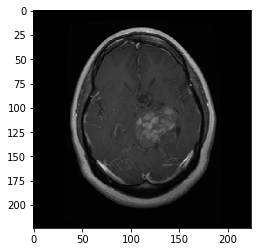

[[0.1443792]]
it has Brain tumor


In [61]:
detect("/content/val/Brain Tumor/Cancer (1).jpg")

Welcome To BrainCancer Detection Program


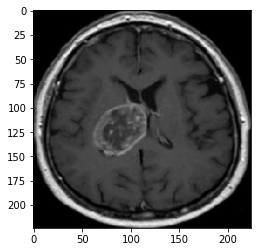

[[0.2911809]]
it has Brain tumor


In [62]:
detect("/content/val/Brain Tumor/Cancer (10).tif")

Welcome To BrainCancer Detection Program


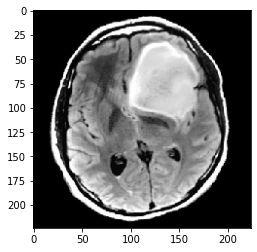

[[0.1710343]]
it has Brain tumor


In [63]:
detect("/content/val/Brain Tumor/Cancer (1080).jpg")

Welcome To BrainCancer Detection Program


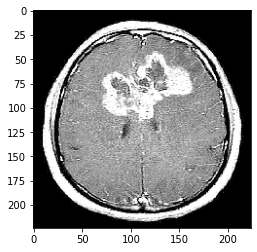

[[0.10150906]]
it has Brain tumor


In [64]:
detect("/content/val/Brain Tumor/Cancer (1535).jpg")

Welcome To BrainCancer Detection Program


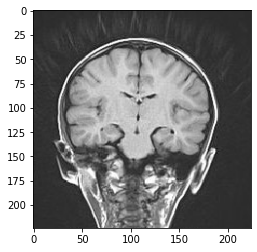

[[0.787375]]
it has no Brain tumor


In [65]:
detect("/content/val/Healthy/Not Cancer  (103).jpg")

Welcome To BrainCancer Detection Program


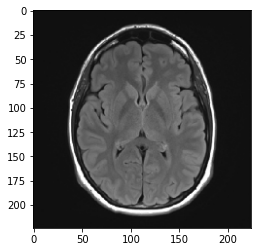

[[0.90782297]]
it has no Brain tumor


In [69]:
detect("/content/val/Healthy/Not Cancer  (1035).jpg")

Welcome To BrainCancer Detection Program


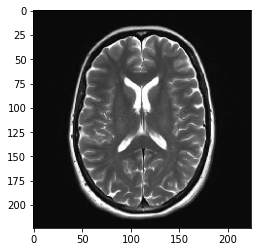

[[0.98883384]]
it has no Brain tumor


In [70]:
detect("/content/train/Healthy/Not Cancer  (10).jpg")